In [1]:
%matplotlib inline
# packages to load 
# Check the versions of libraries
# Python version
import warnings
warnings.filterwarnings('ignore')
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import (PCA, LatentDirichletAllocation)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import f_regression
# Importing metrics for evaluation

from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, GradientBoostingClassifier )
from sklearn.linear_model import LogisticRegression


import random as rn
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras import initializers
from keras.callbacks import (TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from biosppy.signals import (ecg, tools)
import pywt
from tqdm import tqdm_notebook as tqdm

import math
from itertools import product
# ============= CONSTS =============
TRAIN_FILE_PATH = "data/X_train.csv"
TARGET_FILE_PATH =  "data/y_train.csv"
TEST_FILE_PATH = "data/X_test.csv"

seed=42
NUM_MAX_POINTS = 18154
SAMPLING_RATE=300
USE_WAVE_LETS = False
my_cols = ["id"] + ["x" + str(i) for i in range(NUM_MAX_POINTS)]
# ============= CONSTS =============

np.random.seed(seed)
rn.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



Python: 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
scipy: 1.1.0


Using TensorFlow backend.


In [4]:
#Load train and test set


train_data = pd.read_csv(TRAIN_FILE_PATH, names=my_cols)[1:]
train_data.drop("id", axis=1, inplace=True)

Y_train = pd.read_csv(TARGET_FILE_PATH)
Y_train.drop("id", axis=1, inplace = True)

test_data =  pd.read_csv(TEST_FILE_PATH, names=my_cols)[1:]
id_test = test_data.columns[0]
test_data.drop("id", axis=1, inplace=True)

In [5]:
## ================ FUNCTION DEFS ================ ##

def make_submission(filename, predictions):
    test_data =  pd.read_csv(TEST_FILE_PATH, names=my_cols)[1:]
    test_data["y"] = predictions
    test_data[["id", "y"]].to_csv("submissions/"+filename, index= False)
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

def get_feature_from_raw(signal, sampling_rate):
    # filter signal
    order = int(0.3 * sampling_rate)
    filtered, _, _ = tools.filter_signal(signal=signal,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)

    # segment
    rpeaks, = ecg.hamilton_segmenter(signal=filtered, sampling_rate=sampling_rate)

    # correct R-peak locations
    rpeaks, = ecg.correct_rpeaks(signal=filtered,
                             rpeaks=rpeaks,
                             sampling_rate=sampling_rate,
                             tol=0.05)

    # extract templates
    templates, rpeaks = ecg.extract_heartbeats(signal=filtered,
                                           rpeaks=rpeaks,
                                           sampling_rate=sampling_rate,
                                           before=0.2,
                                           after=0.4)
    return templates
    
def get_features_from_raw_qrs(signal, sampling_rate):
    X = np.zeros((16 + (3*180)), dtype=np.float64)
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal, sampling_rate, show=False)
    rpeaks = ecg.correct_rpeaks(signal=signal, rpeaks=rpeaks, sampling_rate=sampling_rate, tol=0.1)
    
    
    peaks = signal[rpeaks]
    if len(heart_rate) < 2:
        heart_rate = [0, 1]
    if len(heart_rate_ts) < 2:
        heart_rate_ts = [0, 1]
        
    X[0] = np.mean(peaks)
    X[1] = np.min(peaks)
    X[2] = np.max(peaks)
    
    X[3] = np.mean(np.diff(rpeaks))
    X[4] = np.min(np.diff(rpeaks))
    X[5] = np.max(np.diff(rpeaks))
    
    X[6] = np.mean(heart_rate)
    X[7] = np.min(heart_rate)
    X[8] = np.max(heart_rate)
    
    X[9] = np.mean(np.diff(heart_rate))
    X[10] = np.min(np.diff(heart_rate))
    X[11] = np.max(np.diff(heart_rate))
    
    X[12] = np.mean(np.diff(heart_rate_ts))
    X[13] = np.min(np.diff(heart_rate_ts))
    X[14] = np.max(np.diff(heart_rate_ts))
    
    X[15] = np.sum(filtered-signal)
    
    X[16:180+16] = np.mean(templates, axis=0)
    X[180+16:2*180+16] = np.min(templates, axis=0)
    X[2*180+16:] = np.max(templates, axis=0)
    
    X[np.isnan(X)] = 0
    return X
    
    
def get_weights(Y, N):
    cnt_0 = np.sum(Y == 0)
    cnt_1 = np.sum(Y == 1)
    cnt_2 = np.sum(Y == 2)
    cnt_3 = np.sum(Y == 3)
    return {0: cnt_0 / N, 1: cnt_1 / N, 2: cnt_2 / N, 3: cnt_3 / N}

In [6]:
features = list()
sampling_rate = float(SAMPLING_RATE)
for id in tqdm(range(train_data.shape[0])):
    signal = np.array(pd.to_numeric(train_data.iloc[id].dropna()))
    if USE_WAVE_LETS:
        features.append(get_feature_from_raw(signal, sampling_rate))
    else:
        features.append(get_features_from_raw_qrs(signal, sampling_rate))

In [7]:
# precrosses 
if USE_WAVE_LETS:
    X_features = list ()
    y = list()
    for idx, sig in enumerate(features):
        mean = 0
        cnt = 0

        for p in sig:
            mean += p
            cnt += 1
        if cnt > 0:
            X_features.append(mean / cnt)
            y.append(Y_train.iloc[idx])
        else:
            print("{}: Cnt is equal to zero".format(idx))

    X, _ = pywt.dwt(X_features, 'db1')
    y = np.array(y)
else:
    X = np.array(features)
    y = np.array(Y_train.values)

# Get features from test data

In [8]:
features_test = list()
for id in tqdm(range(test_data.shape[0])):
    signal = np.array(pd.to_numeric(test_data.iloc[id].dropna()))
    if USE_WAVE_LETS:
        features_test.append(get_feature_from_raw(signal, sampling_rate))
    else:
        features_test.append(get_features_from_raw_qrs(signal, sampling_rate))
            

In [9]:
if USE_WAVE_LETS:
    X_features_test = list ()
    for sig in features_test:
        mean = 0
        cnt = 0
        for p in sig:
            mean += p
            cnt += 1
        X_features_test.append(mean / cnt)

    X_test, _ = pywt.dwt(X_features_test, 'db1')
else:
    X_test = np.array(features_test)

# Save features to memory

In [10]:
# Export to CSV
print(X.shape)
print(y.shape)
print(X_test.shape)
if USE_WAVE_LETS:
    pd.DataFrame(data=X).to_csv("data/X_train_features.csv", index=False)
    pd.DataFrame(data=y).to_csv("data/y_train_features.csv", index=False)
    pd.DataFrame(data=X_test).to_csv("data/X_test_features.csv", index=False)
else:
    pd.DataFrame(data=X).to_csv("data/X_train_features_qrs.csv", index=False)
    pd.DataFrame(data=y).to_csv("data/y_train_features_qrs.csv", index=False)
    pd.DataFrame(data=X_test).to_csv("data/X_test_features_qrs.csv", index=False)

(5117, 556)
(5117, 1)
(3411, 556)


In [2]:
# read from csv
if USE_WAVE_LETS:
    X= pd.read_csv("data/X_train_features.csv").values
    y= pd.read_csv("data/y_train_features.csv").values
    X_test= pd.read_csv("data/X_test_features.csv").values
else:
    X= pd.read_csv("data/X_train_features_qrs.csv").values
    y= pd.read_csv("data/y_train_features_qrs.csv").values
    X_test= pd.read_csv("data/X_test_features_qrs.csv").values
print(X.shape)
print(y.shape)
print(X_test.shape)

(5117, 556)
(5117, 1)
(3411, 556)


# Define classifiers

In [18]:
mlp = MLPClassifier(solver='adam',
                           activation='relu',
                           learning_rate='adaptive',
                           max_iter=2000,
                           random_state=seed,
                           hidden_layer_sizes=(10,10,10),
                           verbose=False)

gb = GradientBoostingClassifier(random_state=seed,
                                       n_estimators=100,
                                       max_depth=5,
                                       learning_rate=0.1)

rf = RandomForestClassifier(n_estimators=2000,
                                       random_state=seed,
                                       n_jobs=-1,
                                       verbose=False)

lr = LogisticRegression(solver="lbfgs",
                                   multi_class="multinomial",
                                   max_iter=2000,
                                   random_state=seed,
                                   class_weight='balanced')

classifiers = [mlp, gb, rf, lr]
classifiers_names = ["MLPClassifier", "GradientBoostingClassifier", "RandomForestClassifier", "LogisticRegression"]

# Do predictions with k fold cross validation

In [47]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
clf_scores_avg = []
clf_scores_std = []

print("Start")
for clf in tqdm(classifiers):
    F1_scores = []
    for train, test in tqdm(kfold.split(X, y)):
        X_fold = X[train]
        y_fold = y[train]
        X_fold_test = X[test]
        y_valid = y[test]
        
        scaler = StandardScaler() 
        scaler.fit(X_fold)

        x_train_scaled = scaler.transform(X_fold)
        x_test_scaled = scaler.transform(X_fold_test)

        #class_weight = get_weights(y_fold, X_fold.shape[0])

        clf.fit(x_train_scaled, y_fold)

        y_pred = clf.predict(x_test_scaled)
        y_true = y[test]
        cur_F1 = f1_score(y_true, y_pred, average='micro')
        F1_scores.append(cur_F1)
        
    clf_scores_avg.append(np.mean(F1_scores))
    clf_scores_std.append(np.std(F1_scores))
for i in range(4):
    print(f"{classifiers_names[i]} F1 avg score {clf_scores_avg[i]} +/- {clf_scores_std[i]}" )

Start


MLPClassifier F1 avg score 0.7105722026002983 +/- 0.017701592826777298
GradientBoostingClassifier F1 avg score 0.8026085744469622 +/- 0.01870012924130941
RandomForestClassifier F1 avg score 0.7832691418662714 +/- 0.013150557174098193
LogisticRegression F1 avg score 0.678134954013649 +/- 0.017364794392204938


# SUBMISSION

Start fitting


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GBC done


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RFC done


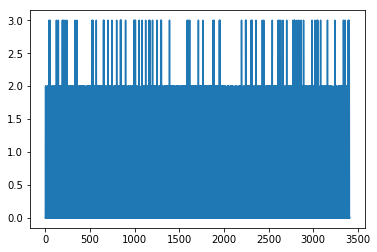

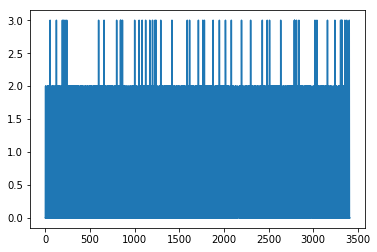

In [11]:
scaler = StandardScaler() 
scaler.fit(X)
x_train_scaled = scaler.transform(X)
x_test_scaled = scaler.transform(X_test)

print("Start fitting")
gb = GradientBoostingClassifier(random_state=seed,
                                       n_estimators=100,
                                       max_depth=5,
                                       learning_rate=0.1)

rf = RandomForestClassifier(n_estimators=2000,
                                       random_state=seed,
                                       n_jobs=-1,
                                       #class_weight=class_weight,
                                       verbose=False)


gb.fit(x_train_scaled, y)
prediction = gb.predict(x_test_scaled)
make_submission("ax_GBC.csv", prediction)
print("GBC done")
plt.figure()
plt.plot(prediction)

rf.fit(x_train_scaled, y)
prediction_rf = rf.predict(x_test_scaled)
make_submission("ax_RFC_no_weight.csv", prediction_rf)
print("RFC done")
plt.figure()
plt.plot(prediction_rf)


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RFC done


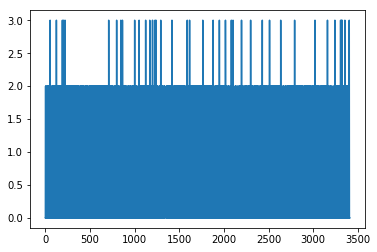

In [12]:
class_weight = get_weights(y, X.shape[0])
rfc = RandomForestClassifier(n_estimators=2000,
                                       random_state=seed,
                                       n_jobs=-1,
                                       class_weight=class_weight,
                                       verbose=False)
rfc.fit(x_train_scaled, y)
prediction_rfc = rfc.predict(x_test_scaled)
make_submission("ax_RFC_weight.csv", prediction_rfc)
print("RFC done")
plt.figure()
plt.plot(prediction_rfc)

# Ploting of the data

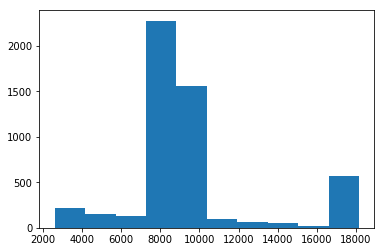

In [15]:
histData = list()
for id in tqdm(range(train_data.shape[0])):
    histData.append(len(train_data.iloc[id].dropna()))
    
plt.hist(histData);

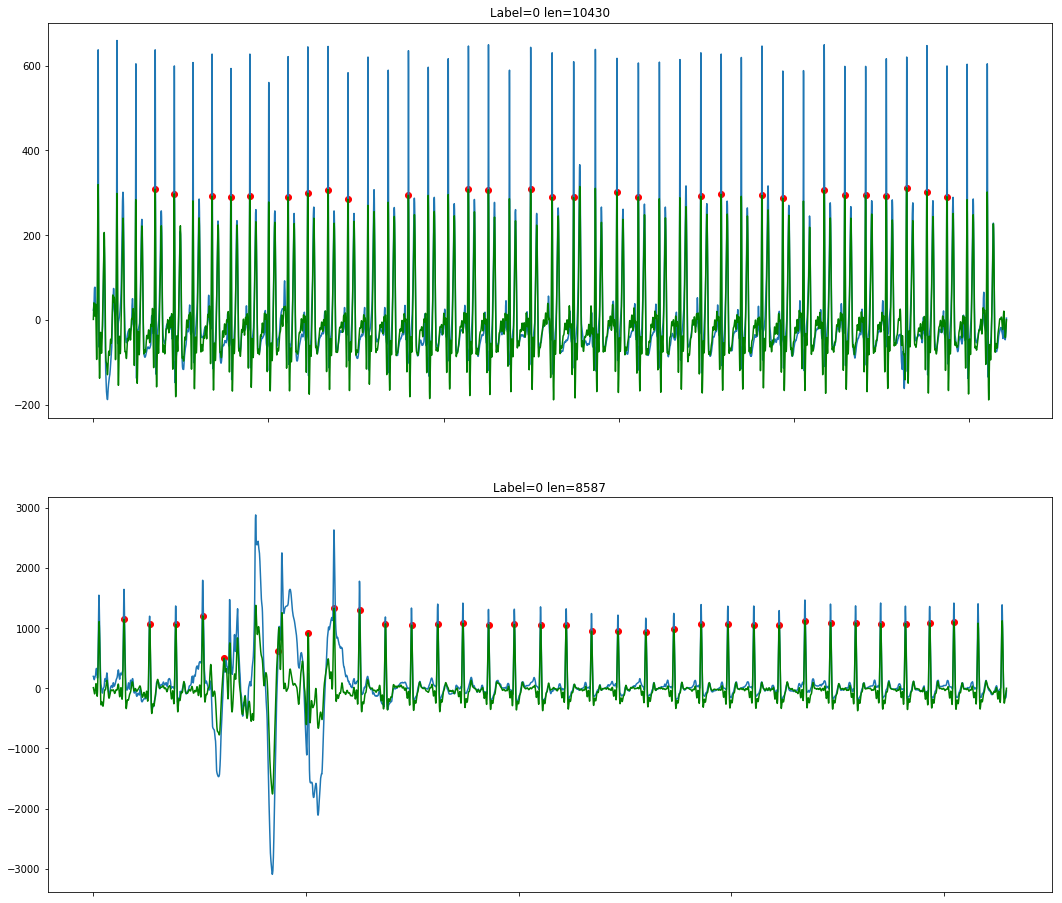

In [24]:
# plot n random entries
plt_count = 2
ids = np.random.randint(train_data.shape[0], size=plt_count)
fig, ax = plt.subplots(nrows=plt_count, figsize=(18, 16))
i = 0
for id in ids:
    row = train_data.iloc[id].dropna()
    out = ecg.ecg(signal=row.values, show=False)
    
    label = Y_train["y"][id]
    ax[i].set_title("Label={} len={}".format(label, row.count()))
    row.plot(ax=ax[i])
    # filtered
    filtered_sig = out[1]
    r_peak_index = out[2]
    ax[i].plot(filtered_sig, color='green')
    # r peaks
    ax[i].scatter(r_peak_index, [filtered_sig[i] for i in r_peak_index], color='red', marker="o")
    i += 1

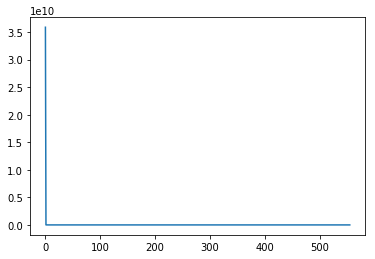

In [3]:
pca = PCA()
pca.fit(X)
plt.plot(pca.explained_variance_);


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(5117, 2)
(5117,)
explained variance ratio (first two components): [9.99629814e-01 1.59496391e-04]


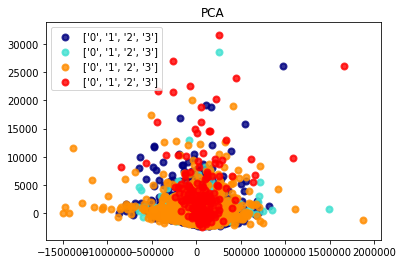

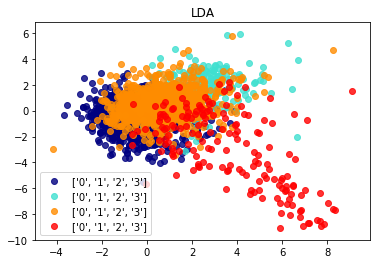

In [4]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

print(X_r.shape)
print(np.squeeze(y == 1).shape)
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'red']
target_names = ["0", "1", "2", "3"]
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    plt.scatter(X_r[np.squeeze(y == i), 0], X_r[np.squeeze(y == i), 1], color=color, alpha=.8, lw=lw, label=target_names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    plt.scatter(X_r2[np.squeeze(y == i), 0], X_r2[np.squeeze(y == i), 1], alpha=.8, color=color, label=target_names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA')

plt.show()